In [28]:
%reload_ext autoreload
%autoreload 2
import os
import shapley_value
import pandas as pd
import numpy as np
from getting_data import read_conf
from xai_process import get_smp_shap_data
from s2search_score_pdp import pdp_based_importance

ds_list = [
    'cslg', 'cscv', 'csai', 'csit', 'cscl',
    'cscr', 'csds', 'cssy', 'csni', 'csro',
    'csdc', 'cssi', 'cslo', 'csna', 'cscy',
    'csdm', 'csir', 'csne', 'csse', 'cscc',
    'cshc', 'csgt', 'cssd', 'csdb', 'cscg',
    'cspl', 'csma', 'csce', 'csfl', 'csdl',
    'csmm', 'csgr', 'cspf', 'csar', 'cset', 
    'csoh', 'cssc', 'csms',
]

In [40]:
xai_metrics_arr = []

def aggregation(arr):
    # return np.std(arr)
    # return np.mean(np.abs(arr))
    return pdp_based_importance(arr)

for sample_name in ds_list:
    exp_name = f'exp-{sample_name}'
    exp_path = os.path.join('.', f'pipelining/{exp_name}')
    sv = shapley_value.compute_shapley_value(exp_name, sample_name)
    
    data_len = sv.shape[0]

    sv_fi = [
        aggregation(sv[col])
        for col in sv.columns
    ]
    
    ale_fi = []
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        ale_npz_file = os.path.join(exp_path, 'scores', f'{sample_name}_1w_ale_{feature_name}.npz')
        ale_fi.append(aggregation(np.load(ale_npz_file)['ale_result']))
    

    anchor_fi = []
    _, sample_configs, __  = read_conf(exp_path)
    metrics = dict(
        title=[],
        abstract=[],
        venue=[],
        authors=[],
        year=[],
        n_citations=[],
    )
    for sample_key in sample_configs.keys():
        sample_tasks = sample_configs[sample_key]['anchor']['task']
        for task in sample_tasks:
            rg = task['range']
            m_file = os.path.join(exp_path, 'scores', f"{sample_key}_anchor_metrics_{rg[0]}_{rg[1]}.npz")
            if os.path.exists(m_file):
                ld = np.load(m_file)
                title = ld['title']
                abstract = ld['abstract']
                venue = ld['venue']
                authors = ld['authors']
                year = ld['year']
                n_citations = ld['n_citations']
                idx = ld['idx']
                
                metrics['title'].extend(title)
                metrics['abstract'].extend(abstract)
                metrics['venue'].extend(venue)
                metrics['authors'].extend(authors)
                metrics['year'].extend(year)
                metrics['n_citations'].extend(n_citations)
                
    for feature_name in ['title', 'abstract', 'venue', 'authors', 'year', 'n_citations']:
        if len(metrics[feature_name]) < data_len:
            zeros = np.zeros([data_len - len(metrics[feature_name])])
            metrics[feature_name].extend(list(zeros))
        anchor_fi.append(aggregation(metrics[feature_name]))
    
    shap_fi = []
    shap_sv = get_smp_shap_data(exp_name)[sample_name]['shap_sv']
                
    shap_sv = np.flipud(np.rot90(np.array(shap_sv)))
    for feature_sv in shap_sv:
        shap_fi.append(aggregation(feature_sv))
                
    xai_metrics_arr.append([
        sample_name,
        ale_fi, 
        sv_fi,
        anchor_fi,
        shap_fi
    ])
    
fis = ['ale Feature Importance', 'sv Feature Importance', 'anchor Feature Importance', 'shap Feature Importance']

xai_fi_metrics_pd = pd.DataFrame(columns=['dataset', *fis], data=xai_metrics_arr)

xai_fi_metrics_pd

,dataset,ale Feature Importance,sv Feature Importance,anchor Feature Importance,shap Feature Importance
0,cslg,"[3.0294130674, 6.1806846866, 1.7377042619, 1.7...","[5.2018267992, 8.057841891, 1.7172171987, 0.11...","[0.2441248861, 0.2431968493, 0.0422471316, 0.0...","[3.0996696638, 6.2764447104, 1.2018174697, 0.0..."
1,cscv,"[2.2341302745, 5.6069839596, 6.2777171507, 1.1...","[1.8000268021, 6.723272921, 7.8778583752, 0.09...","[0.1160051294, 0.3461766364, 0.3592728403, 0.0...","[1.2718786166, 5.2755507147, 6.4106656049, 0.0..."
2,csai,"[1.7737136774, 5.7737319125, 1.9332162495, 0.7...","[4.4397727985, 7.3156086991, 1.1774237199, 0.0...","[0.2218556074, 0.2604633733, 0.0384757984, 0.0...","[2.9424836068, 5.8300692776, 0.8568463126, 0.0..."
3,csit,"[2.3541428406, 4.758696453, 6.8113280964, 0.0,...","[2.6406140398, 5.8721938909, 8.8829530199, 0.0...","[0.0973776141, 0.2946622201, 0.2479996034, 0.0...","[1.5004290018, 4.3055726092, 6.6530487832, 0.0..."
4,cscl,"[2.0860214409, 6.9617332654, 1.9895988001, 0.0...","[4.2292161003, 8.8503714064, 1.3874476416, 0.0...","[0.2036775508, 0.2657464566, 0.0569761724, 0.0...","[2.697856526, 7.2175577061, 0.8859807504, 0.02..."
5,cscr,"[1.4857960409, 9.6774945004, 3.9721594947, 0.0...","[5.2140769131, 10.5629898427, 4.5872296028, 0....","[0.1769871968, 0.2889569335, 0.107313771, 0.02...","[3.0373394475, 8.3701088374, 3.0511279058, 0.0..."
6,csds,"[5.457289587, 9.1743767091, 2.8526545204, 0.0,...","[6.1066548746, 10.9425733617, 2.7185507144, 0....","[0.175884092, 0.3208147706, 0.0878190156, 0.02...","[4.0504376153, 8.7556889837, 1.7012818388, 0.0..."
7,cssy,"[3.554092928, 4.2878364887, 2.9700983277, 1.04...","[5.1592835903, 7.1168357769, 4.9399078591, 0.0...","[0.1762477147, 0.1766013932, 0.1281200582, 0.0...","[3.1843467816, 5.2039432971, 2.9369073294, 0.0..."
8,csni,"[2.3613356419, 6.8280574463, 2.9119162225, 0.0...","[5.0029490762, 7.0464194849, 2.6020481337, 0.0...","[0.1871056283, 0.2138648882, 0.0909618235, 0.0...","[3.1843880586, 5.4199603725, 1.6197665972, 0.0..."
9,csro,"[2.8435514989, 5.792678976, 8.1167709389, 3.26...","[2.753987797, 6.6117502268, 9.6212491293, 0.10...","[0.0839592875, 0.1644941586, 0.3156243401, 0.0...","[2.1002797512, 5.0389721969, 7.6658973527, 0.0..."


check data in csv

In [30]:
# xai_fi_metrics_pd.to_csv('fi.csv')

set data

In [31]:
datafi = xai_fi_metrics_pd
data_ale_fi = datafi['ale Feature Importance']
data_sv_fi = datafi['sv Feature Importance']
data_anchor_fi= datafi['anchor Feature Importance']
data_shap_fi = datafi['shap Feature Importance']


In [32]:
mode_map = {}
method_median_order = []

for fi in fis:
    fi_data = (xai_fi_metrics_pd[fi].to_list())
    
    method_median_order.append([np.median(v) for v in np.transpose(fi_data)])
    
    mp = {}
    mode_map[fi] = mp
    for one_fi in fi_data:
        order = str(np.flip(np.argsort(one_fi)))
        if mp.get(order) == None:
            mp[order] = 0
        mp[order] += 1
              
ale_median_order, sv_median_order, anchors_median_order, shap_median_order = method_median_order

pos_count = [
    {},
    {},
    {},
    {},
    {},
    {},
]

for k in mode_map.keys():
    print(k)
    for kk in mode_map[k].keys():
        # print(kk, " | ", mode_map[k][kk])
        c = int(mode_map[k][kk])
        idx = kk.replace(']','').replace('[','').split(' ')
        for i in range(6):
            p = idx[i]
            pc = pos_count[i]
            if p not in pc.keys():
                pc[str(p)] = 0
            pc[str(p)] += c
   
for i in range(6):
    pc = pos_count[i]
    mx = None
    for idx in pc.keys():
        if mx == None or pc[idx] > pc[mx]:
            mx = idx
    print(i, mx, pc[mx])
# '''ale Feature Importance: '[1 0 2 4 5 3]': 13'''
# '''sv Feature Importance: '[1 0 2 4 5 3]': 27'''
# '''anchor Feature Importance:'[1 0 4 2 5 3]': 13'''
# ''''shap Feature Importance: '[1 0 2 4 5 3]': 24'''


ale Feature Importance
sv Feature Importance
anchor Feature Importance
shap Feature Importance
0 1 127
1 0 97
2 2 76
3 4 100
4 5 118
5 3 136


kendall_tau_distance

In [33]:
import pandas as pd
import numpy as np
# import seaborn as sns
import scipy.stats as ss 

In [34]:


def normalised_kendall_tau_distance(values1, values2):
    """Compute the Kendall tau distance."""
    n = len(values1)
    assert len(values2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(values1)
    b = np.argsort(values2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))

def convect_rank(data):
  rank_list = []
  for i in range(len(data)):
    rank = []
    rank = data[i]
    trank = np.flip(np.argsort(rank))
    rank_list.append(trank)
  return rank_list


ale_rank = convect_rank(data_ale_fi)
sv_rank = convect_rank(data_sv_fi)
anchor_rank = convect_rank(data_anchor_fi)
shap_rank = convect_rank(data_shap_fi)

def KDT_baseline(ale_rank,sv_rank,anchor_rank,shap_rank):
  KDT_distance_ale = []
  KDT_distance_sv = []
  KDT_distance_anchor = []
  KDT_distance_shap = []
  for i in range(len(sv_rank)):
    KDT_distance_ale.append(normalised_kendall_tau_distance(sv_rank[i],ale_rank[i]))
    KDT_distance_sv.append(normalised_kendall_tau_distance(sv_rank[i],sv_rank[i]))
    KDT_distance_anchor.append(normalised_kendall_tau_distance(sv_rank[i],anchor_rank[i]))
    KDT_distance_shap.append(normalised_kendall_tau_distance(sv_rank[i],shap_rank[i]))
  return np.transpose((KDT_distance_ale, KDT_distance_anchor,KDT_distance_shap))


def KDT_Fixed(ale_rank,sv_rank,anchor_rank,shap_rank):
  KDT_distance_ale = []
  KDT_distance_sv = []
  KDT_distance_anchor = []
  KDT_distance_shap = []
  for i in range(len(sv_rank)):
    KDT_distance_ale.append(normalised_kendall_tau_distance(([1, 0, 2, 4, 5, 3]),ale_rank[i]))
    KDT_distance_sv.append(normalised_kendall_tau_distance(([1, 0, 2, 4, 5, 3]),sv_rank[i]))
    KDT_distance_anchor.append(normalised_kendall_tau_distance(([1, 0, 2, 4, 5, 3]),anchor_rank[i]))
    KDT_distance_shap.append(normalised_kendall_tau_distance(([1, 0, 2, 4, 5, 3]),shap_rank[i]))
  return np.transpose((KDT_distance_ale, KDT_distance_sv, KDT_distance_anchor,KDT_distance_shap))

def KDT_Self(ale_rank,sv_rank,anchor_rank,shap_rank):
  KDT_distance_ale = []
  KDT_distance_sv = []
  KDT_distance_anchor = []
  KDT_distance_shap = []
  ale_o = np.flip(np.argsort(ale_median_order))
  sv_o = np.flip(np.argsort(sv_median_order))
  anchor_o = np.flip(np.argsort(anchors_median_order))
  shap_o = np.flip(np.argsort(shap_median_order))
  
  for i in range(len(sv_rank)):
    KDT_distance_ale.append(normalised_kendall_tau_distance(ale_o ,ale_rank[i]))
    KDT_distance_sv.append(normalised_kendall_tau_distance(sv_o,sv_rank[i]))
    KDT_distance_anchor.append(normalised_kendall_tau_distance(anchor_o,anchor_rank[i]))
    KDT_distance_shap.append(normalised_kendall_tau_distance(shap_o,shap_rank[i]))
  return np.transpose((KDT_distance_ale, KDT_distance_sv, KDT_distance_anchor,KDT_distance_shap))

Results:

In [35]:
distance_baseline = KDT_baseline(ale_rank,sv_rank,anchor_rank,shap_rank)
distance_baseline = np.transpose(distance_baseline)

In [36]:
distance_self = KDT_Self(ale_rank,sv_rank,anchor_rank,shap_rank)
distance_self = np.transpose(distance_self)

Plot:

[0.0947, 0.0281, 0.1158, 0.0368]


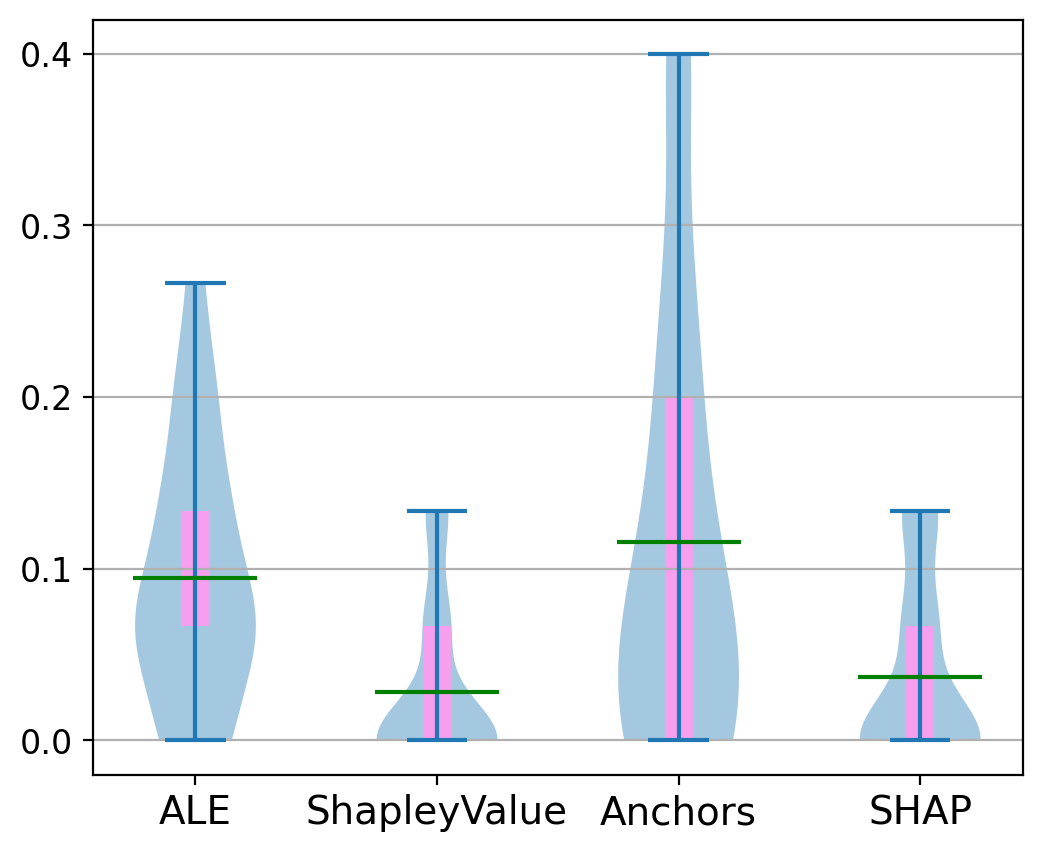

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

parts = ax.violinplot(np.transpose(distance_self), showmeans=False, showmedians=False,
        showextrema=True)

for pc in parts['bodies']:
    # pc.set_facecolor('#029386')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.4)

quartile1, medians, quartile3 = np.percentile(distance_self, [25, 50, 75], axis=1)

average = np.mean(distance_self, axis=1)

print([round(a, 4) for a in average])

inds = np.arange(1, len(medians) + 1)
# ax.scatter(inds, medians, marker='_', color='#ff6347', s=1500, zorder=3, alpha=0.7)
ax.scatter(inds, average, marker='_', color='green', s=2000, zorder=3, alpha=1)
ax.vlines(inds, quartile1, quartile3, color='#f79fef', linestyle='-', lw=10, zorder=1, alpha=1)

plt.yticks(fontsize=12)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(distance_self))],
                labels=['ALE', 'ShapleyValue', 'Anchors', 'SHAP'], fontsize=14)
# ax.set_xlabel('Method', fontsize=14)
# ax.set_ylabel(f'Kendall tau Distance', fontsize=14)

[0.0737, 0.1509, 0.0123]


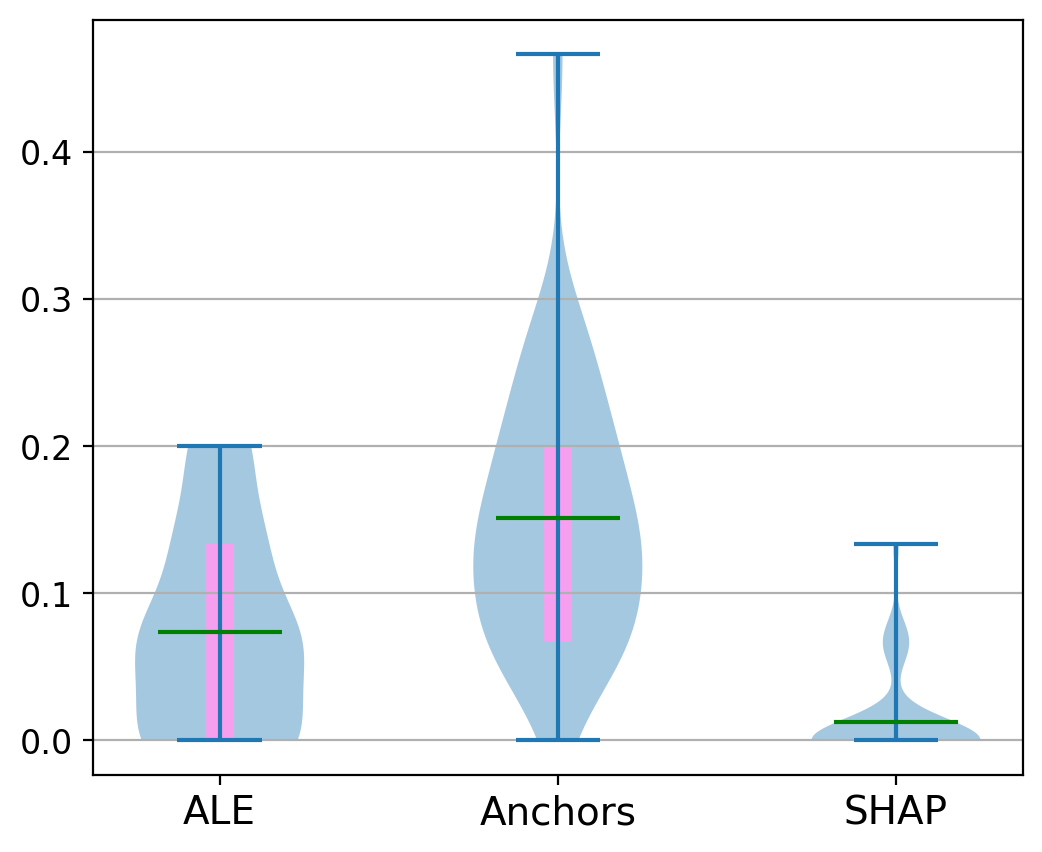

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

parts = ax.violinplot(np.transpose(distance_baseline), showmeans=False, showmedians=False,
        showextrema=True)

for pc in parts['bodies']:
    # pc.set_facecolor('#029386')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.4)

quartile1, medians, quartile3 = np.percentile(distance_baseline, [25, 50, 75], axis=1)

average = np.mean(distance_baseline, axis=1)

print([round(a, 4) for a in average])

inds = np.arange(1, len(medians) + 1)
# ax.scatter(inds, medians, marker='_', color='#ff6347', s=1500, zorder=3, alpha=1)
ax.scatter(inds, average, marker='_', color='green', s=2000, zorder=3, alpha=1)
ax.vlines(inds, quartile1, quartile3, color='#f79fef', linestyle='-', lw=10, zorder=1)

plt.yticks(fontsize=12)
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(distance_baseline))],
                labels=['ALE', 'Anchors', 'SHAP'], fontsize=14)
# ax.set_xlabel('Method', fontsize=14)
# ax.set_ylabel(f'Kendall tau Distance', fontsize=14)


[0.0912, 0.0281, 0.1614, 0.0368]


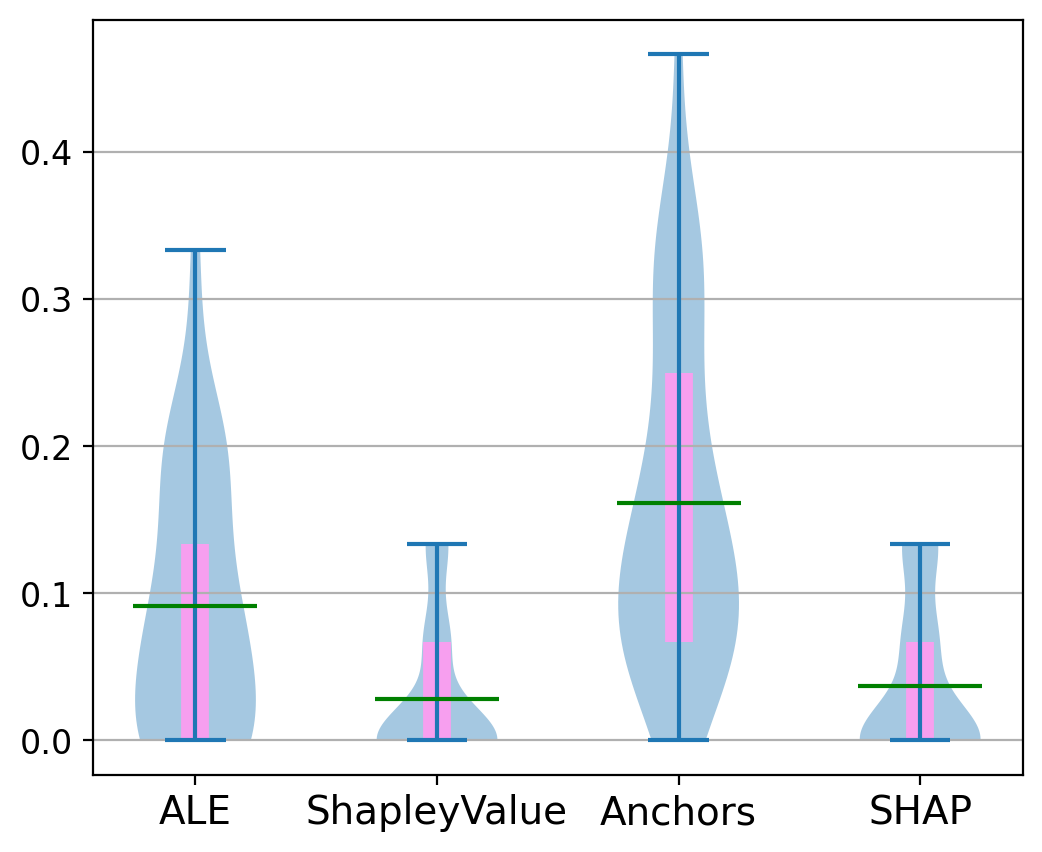

In [39]:
distance_fixed = KDT_Fixed(ale_rank,sv_rank,anchor_rank,shap_rank)
distance_fixed = np.transpose(distance_fixed)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5), dpi=200)

parts = ax.violinplot(np.transpose(distance_fixed), showmeans=False, showmedians=False,
        showextrema=True)

for pc in parts['bodies']:
    # pc.set_facecolor('#029386')
    # pc.set_edgecolor('black')
    pc.set_alpha(0.4)

quartile1, medians, quartile3 = np.percentile(distance_fixed, [25, 50, 75], axis=1)

average = np.mean(distance_fixed, axis=1)

print([round(a, 4) for a in average])

inds = np.arange(1, len(medians) + 1)
# ax.scatter(inds, medians, marker='_', color='#ff6347', s=1500, zorder=3, alpha=0.7)
ax.scatter(inds, average, marker='_', color='green', s=2000, zorder=3, alpha=1)
ax.vlines(inds, quartile1, quartile3, color='#f79fef', linestyle='-', lw=10, zorder=1, alpha=1)

plt.yticks(fontsize=12)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
ax.yaxis.grid(True)
ax.set_xticks([y + 1 for y in range(len(distance_fixed))],
                labels=['ALE', 'ShapleyValue', 'Anchors', 'SHAP'], fontsize=14)
# ax.set_xlabel('Method', fontsize=14)
# ax.set_ylabel(f'Kendall tau Distance', fontsize=14)